### 导入一些需要用到的库

In [1]:
import tushare as ts
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

### 获取某股票最近若干天的前复权数据

In [43]:
def get_data(code,end='2018-01-01', duration=365):
    
    # 打印股票的基本信息
    df = ts.get_stock_basics()
    print(df.loc[code][['name', 'industry', 'timeToMarket']])
    
    d1 = datetime.datetime.strptime(end,'%Y-%m-%d')
    d2 = d1 - datetime.timedelta(days=duration)
    start = d2.strftime('%Y-%m-%d')

    return ts.get_h_data(code, start=start, end=end)

### 一个例子 -- 获取数据，保存文件，可视化

In [44]:
code = '300222'

data = get_data(code, duration=365*3)

name                科大智能
industry            电气设备
timeToMarket    20110525
Name: 300222, dtype: object
[Getting data:]############

In [45]:
data.to_csv('stock_data_730.csv')

In [2]:
data = pd.read_csv('stock_data_730.csv')

In [3]:
data.set_index(["date"], inplace=True)

data_sorted = data.sort_index()

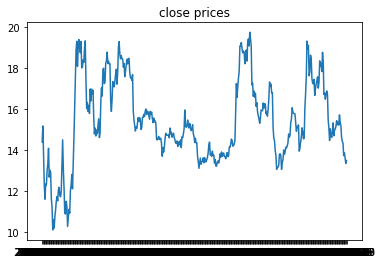

In [4]:
plt.plot(data_sorted.close)
plt.title('close prices')
plt.show()

### 将数据集分割为训练集和测试集

In [8]:
def train_test_split(data,SEQ_LENGTH = 25,test_prop=0.137):  # 0.11 for 1095, 0.137 for 730, 0.3 for 365
    
    ntrain = int(len(data) *(1-test_prop))  # len(data) = 197
    predictors = data.columns[:4]  # open, high, close, low
    data_pred = data[predictors]
    num_attr = data_pred.shape[1]  # 4
    
    result = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH, num_attr))
    y = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH))
    yopen = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH))

    for index in range(len(data) - SEQ_LENGTH):
        result[index, :, :] = data_pred[index: index + SEQ_LENGTH]
        y[index, :] = data_pred[index+1: index + SEQ_LENGTH + 1].close
        yopen[index, :] = data_pred[index+1: index + SEQ_LENGTH + 1].open

    """
        xtrain的大小：ntrain x SEQ_LENGTH x 4
        ytrain的大小：ntrain x SEQ_LENGTH
        
        * xtrain的每个batch为长为SEQ_LENGTH的连续序列，一共有ntrain个batch，
          序列中每个单元都是一个四元组（open，high，close，low）
        * ytrain的每个batch为长为SEQ_LENGTH的连续序列，一共有ntrain个batch，
          序列中每个单元是xtrain中对应四元组所在日期的下一天的close price
        
        xtest 的大小：    ntest x SEQ_LENGTH x 4                
        ytest的大小：     ntest x SEQ_LENGTH      (close price)
        ytest_open的大小：ntest x SEQ_LENGTH      (open price)  
        
        * xtest的每个batch为长为SEQ_LENGTH的连续序列，一共有ntest个batch，
          序列中每个单元都是一个四元组（open，high，close，low）
          每一个序列仅包含一个新四元组，且在最后一个
        * ytest的每个batch为长为SEQ_LENGTH的连续序列，一共有ntest个batch，
          序列中每个单元是xtest中对应四元组所在日期的下一天的close price
        
        类型：numpy.ndarray
    """
    xtrain = result[:ntrain, :, :]
    ytrain = y[:ntrain]
    
    xtest = result[ntrain:, :, :]
    ytest = y[ntrain:]
    ytest_open = yopen[ntrain:]
    
    return xtrain, xtest, ytrain, ytest, ytest_open

In [9]:
xtrain, xtest, ytrain, ytest, ytest_open = train_test_split(data_sorted)

# 转为tensor
xtrain = torch.from_numpy(xtrain)
ytrain = torch.from_numpy(ytrain)

xtest = torch.from_numpy(xtest)
ytest = torch.from_numpy(ytest)

In [10]:
xtrain.shape

torch.Size([372, 25, 4])

In [11]:
ytrain.shape

torch.Size([372, 25])

In [12]:
xtest.shape

torch.Size([35, 25, 4])

In [13]:
ytest.shape

torch.Size([35, 25])

### 读取由GAN生成的数据

In [117]:
gen_data = np.load('time_series.npy')

In [118]:
gen_data = torch.from_numpy(gen_data).double()

In [119]:
gen_data.shape   # 4 attrs: open, high, close, low

torch.Size([100, 26, 4])

In [120]:
gen_xtrain = gen_data[:, :-1, :]
gen_ytrain = gen_data[:, 1: , 2]

In [121]:
gen_xtrain.shape

torch.Size([100, 25, 4])

In [122]:
gen_ytrain.shape

torch.Size([100, 25])

### 定义LSTM模型

In [123]:
class lstm(nn.Module):
    def __init__(self, input_size=4, hidden_size=30, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 使用两层LSTMCell堆积来提高模型表达力
        self.layer1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.layer2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
        
    def forward(self, input_data, future=0):
        outputs = []
        
        # LSTM cell的三个输入：input(batch,input_size), h_0(batch,hidden_size), c_0(batch,hidden_size)
        # batch即为input_data中样本的数量，即为ntrain
        # 此处input_data的大小为：ntrain x SEQ_LENGTH X 4
        
        # init hidden states and cell state for layer1
        h_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        c_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        
        # init hidden states and cell state for layer2
        h_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        c_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        
        # input_data:[ntrain x SEQ_LENGTH X 4]
        # chunk将tensor按第二个维度分成 SEQ_LENGTH 块
        for i, input_t in enumerate(input_data.chunk(input_data.size(1), dim=1)):
            
            # reshape: [ntrain x 1 x 4] => [ntrain x 4] 
            input_t = input_t.squeeze(1)
            
            # 每个input_t是 ntrain x 4 的tensor， batch=ntrain，input_size=4
            h_t, c_t = self.layer1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.layer2(h_t, (h_t2, c_t2))
            
            # output的大小为 ntrainx1
            output = self.linear(h_t2)
            outputs += [output]
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        
        return outputs

### 训练LSTM模型

In [124]:
# 设置随机数种子
np.random.seed(0)
torch.manual_seed(0)

# 构建网络
lstm = lstm().double()
criterion = nn.MSELoss()

# 优化器
optimizer = optim.LBFGS(lstm.parameters(), lr=0.1)

# 开始训练    
for i in range(100):
    print('STEP: ', i)
    
    def closure():
        optimizer.zero_grad()
        
        out = lstm(xtrain)
        loss = criterion(out, ytrain)
        print('loss: %5.3f  ' %(loss.item()), end="")
        loss.backward()
        
        out_gen = lstm(gen_xtrain)
        loss_gen = criterion(out_gen, gen_ytrain)
        print('gen_loss: %5.3f' % (loss_gen.item()))
        loss_gen.backward()
        
        return loss + loss_gen
    
    optimizer.step(closure)

STEP:  0
loss: 243.048  gen_loss: 435.437
loss: 242.763  gen_loss: 435.033
loss: 47.908  gen_loss: 145.131
loss: 11.073  gen_loss: 64.107
loss: 8.444  gen_loss: 54.968
loss: 6.567  gen_loss: 46.646
loss: 5.475  gen_loss: 39.342
loss: 5.074  gen_loss: 32.996
loss: 5.257  gen_loss: 27.763
loss: 5.833  gen_loss: 23.581
loss: 6.511  gen_loss: 20.697
loss: 7.071  gen_loss: 18.919
loss: 7.550  gen_loss: 17.638
loss: 7.986  gen_loss: 16.604
loss: 8.390  gen_loss: 15.726
loss: 8.768  gen_loss: 14.957
loss: 9.124  gen_loss: 14.270
loss: 9.460  gen_loss: 13.643
loss: 9.778  gen_loss: 13.057
loss: 10.083  gen_loss: 12.493
STEP:  1
loss: 10.383  gen_loss: 11.922
loss: 10.683  gen_loss: 11.296
loss: 10.949  gen_loss: 10.547
loss: 10.640  gen_loss: 10.082
loss: 10.305  gen_loss: 10.124
loss: 9.885  gen_loss: 10.236
loss: 9.671  gen_loss: 10.285
loss: 9.580  gen_loss: 10.232
loss: 9.537  gen_loss: 10.055
loss: 9.523  gen_loss: 9.785
loss: 9.500  gen_loss: 9.488
loss: 9.535  gen_loss: 9.099
loss: 9.39

loss: 0.347  gen_loss: 0.765
loss: 0.347  gen_loss: 0.764
STEP:  14
loss: 0.347  gen_loss: 0.763
loss: 0.347  gen_loss: 0.761
loss: 0.347  gen_loss: 0.760
loss: 0.347  gen_loss: 0.759
loss: 0.347  gen_loss: 0.758
loss: 0.347  gen_loss: 0.757
loss: 0.347  gen_loss: 0.756
loss: 0.347  gen_loss: 0.755
loss: 0.347  gen_loss: 0.755
loss: 0.347  gen_loss: 0.754
loss: 0.347  gen_loss: 0.753
loss: 0.347  gen_loss: 0.752
loss: 0.346  gen_loss: 0.752
loss: 0.347  gen_loss: 0.751
loss: 0.347  gen_loss: 0.750
loss: 0.347  gen_loss: 0.749
loss: 0.347  gen_loss: 0.749
loss: 0.347  gen_loss: 0.748
loss: 0.347  gen_loss: 0.747
loss: 0.347  gen_loss: 0.747
STEP:  15
loss: 0.347  gen_loss: 0.746
loss: 0.347  gen_loss: 0.745
loss: 0.347  gen_loss: 0.745
loss: 0.347  gen_loss: 0.744
loss: 0.347  gen_loss: 0.744
loss: 0.347  gen_loss: 0.744
loss: 0.347  gen_loss: 0.743
loss: 0.346  gen_loss: 0.743
loss: 0.346  gen_loss: 0.743
loss: 0.345  gen_loss: 0.743
loss: 0.345  gen_loss: 0.742
loss: 0.344  gen_loss: 

loss: 0.328  gen_loss: 0.594
loss: 0.328  gen_loss: 0.592
loss: 0.328  gen_loss: 0.590
loss: 0.329  gen_loss: 0.589
STEP:  28
loss: 0.329  gen_loss: 0.586
loss: 0.329  gen_loss: 0.584
loss: 0.329  gen_loss: 0.582
loss: 0.330  gen_loss: 0.580
loss: 0.330  gen_loss: 0.578
loss: 0.330  gen_loss: 0.575
loss: 0.331  gen_loss: 0.574
loss: 0.331  gen_loss: 0.572
loss: 0.331  gen_loss: 0.570
loss: 0.331  gen_loss: 0.569
loss: 0.331  gen_loss: 0.568
loss: 0.332  gen_loss: 0.566
loss: 0.332  gen_loss: 0.565
loss: 0.332  gen_loss: 0.564
loss: 0.332  gen_loss: 0.563
loss: 0.332  gen_loss: 0.561
loss: 0.332  gen_loss: 0.560
loss: 0.332  gen_loss: 0.559
loss: 0.332  gen_loss: 0.558
loss: 0.333  gen_loss: 0.557
STEP:  29
loss: 0.333  gen_loss: 0.555
loss: 0.333  gen_loss: 0.554
loss: 0.333  gen_loss: 0.552
loss: 0.334  gen_loss: 0.551
loss: 0.334  gen_loss: 0.549
loss: 0.335  gen_loss: 0.548
loss: 0.335  gen_loss: 0.546
loss: 0.335  gen_loss: 0.544
loss: 0.336  gen_loss: 0.542
loss: 0.336  gen_loss: 

loss: 0.345  gen_loss: 0.223
loss: 0.345  gen_loss: 0.222
loss: 0.345  gen_loss: 0.221
loss: 0.346  gen_loss: 0.220
loss: 0.346  gen_loss: 0.219
loss: 0.346  gen_loss: 0.217
STEP:  42
loss: 0.346  gen_loss: 0.216
loss: 0.347  gen_loss: 0.214
loss: 0.347  gen_loss: 0.213
loss: 0.347  gen_loss: 0.212
loss: 0.347  gen_loss: 0.212
loss: 0.347  gen_loss: 0.211
loss: 0.347  gen_loss: 0.210
loss: 0.347  gen_loss: 0.209
loss: 0.347  gen_loss: 0.208
loss: 0.347  gen_loss: 0.207
loss: 0.347  gen_loss: 0.206
loss: 0.347  gen_loss: 0.205
loss: 0.347  gen_loss: 0.204
loss: 0.347  gen_loss: 0.203
loss: 0.347  gen_loss: 0.202
loss: 0.368  gen_loss: 0.193
loss: 0.366  gen_loss: 0.192
loss: 0.364  gen_loss: 0.191
loss: 0.362  gen_loss: 0.191
loss: 0.361  gen_loss: 0.190
STEP:  43
loss: 0.359  gen_loss: 0.190
loss: 0.358  gen_loss: 0.189
loss: 0.357  gen_loss: 0.189
loss: 0.356  gen_loss: 0.189
loss: 0.355  gen_loss: 0.188
loss: 0.355  gen_loss: 0.188
loss: 0.354  gen_loss: 0.188
loss: 0.353  gen_loss: 

loss: 0.312  gen_loss: 0.058
loss: 0.312  gen_loss: 0.057
loss: 0.312  gen_loss: 0.057
loss: 0.312  gen_loss: 0.057
loss: 0.312  gen_loss: 0.057
loss: 0.312  gen_loss: 0.057
loss: 0.312  gen_loss: 0.056
loss: 0.312  gen_loss: 0.056
STEP:  56
loss: 0.312  gen_loss: 0.056
loss: 0.312  gen_loss: 0.056
loss: 0.312  gen_loss: 0.056
loss: 0.312  gen_loss: 0.056
loss: 0.312  gen_loss: 0.055
loss: 0.312  gen_loss: 0.055
loss: 0.312  gen_loss: 0.055
loss: 0.312  gen_loss: 0.055
loss: 0.312  gen_loss: 0.055
loss: 0.312  gen_loss: 0.055
loss: 0.311  gen_loss: 0.054
loss: 0.311  gen_loss: 0.054
loss: 0.311  gen_loss: 0.054
loss: 0.311  gen_loss: 0.054
loss: 0.311  gen_loss: 0.054
loss: 0.311  gen_loss: 0.054
loss: 0.311  gen_loss: 0.054
loss: 0.311  gen_loss: 0.054
loss: 0.310  gen_loss: 0.053
loss: 0.310  gen_loss: 0.053
STEP:  57
loss: 0.310  gen_loss: 0.053
loss: 0.310  gen_loss: 0.053
loss: 0.310  gen_loss: 0.053
loss: 0.310  gen_loss: 0.053
loss: 0.309  gen_loss: 0.053
loss: 0.309  gen_loss: 

loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.295  gen_loss: 0.033
loss: 0.296  gen_loss: 0.033
STEP:  70
loss: 0.295  gen_loss: 0.033
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.032
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
loss: 0.296  gen_loss: 0.031
STEP:  71
loss: 0.295  gen_loss: 0.031
loss: 0.295  gen_loss: 0.031
loss: 0.295  gen_loss: 0.030
loss: 0.295  gen_loss: 

loss: 0.277  gen_loss: 0.022
loss: 0.277  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
loss: 0.276  gen_loss: 0.022
STEP:  84
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.275  gen_loss: 0.022
loss: 0.274  gen_loss: 0.022
loss: 0.274  gen_loss: 0.022
STEP:  85
loss: 0.274  gen_loss: 0.022
loss: 0.274  gen_loss: 

loss: 0.259  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.258  gen_loss: 0.017
loss: 0.257  gen_loss: 0.017
loss: 0.257  gen_loss: 0.017
loss: 0.257  gen_loss: 0.017
STEP:  98
loss: 0.257  gen_loss: 0.017
loss: 0.257  gen_loss: 0.017
loss: 0.257  gen_loss: 0.017
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
loss: 0.257  gen_loss: 0.016
STEP

### 测试LSTM模型

In [125]:
with torch.no_grad():
    future = 0
    pred = lstm(xtest, future=future)
    loss = criterion(ytest, pred)
    print('test loss:', loss.item())

pred_data = pred.detach().numpy()
test_data = ytest.detach().numpy()

test loss: 0.30901459165520456


In [126]:
# 从每个batch的序列数据中提取出ground truth和预测值

gd_truth = []
pred_val = []

# 每个batch的序列数据中的最后一个是新来的数据，将每个batch中新来的值提取出来
for i in range(len(pred_data)):
    gd_truth.append(test_data[i][-1])
    pred_val.append(pred_data[i][-1])
    
gd_truth = np.array(gd_truth)
pred_val = np.array(pred_val)

In [127]:
print(gd_truth)
print(pred_val)

[18.78 18.32 16.72 16.8  16.49 16.72 16.89 16.73 15.48 15.08 14.47 15.04
 14.74 14.62 14.9  15.33 14.7  14.98 15.03 15.16 15.44 15.24 15.35 15.22
 15.72 15.36 15.19 14.62 14.43 14.34 13.73 13.86 13.61 13.35 13.49]
[17.694472   18.64606454 18.29087208 16.65862202 16.81414712 16.5847933
 17.15946596 17.09750203 16.73083864 15.48599821 14.92896296 14.2722588
 15.02517659 14.94430043 14.59139237 14.76523443 15.30396031 14.76175513
 15.06288595 15.09659787 15.04753438 15.32936647 15.23458465 15.33868213
 15.23071494 15.49826058 15.3214282  15.12657018 14.59000755 14.5683802
 14.24169628 13.76019165 13.94411208 13.91521566 13.35601689]


In [128]:
# 欧式距离

np.linalg.norm(gd_truth - pred_val)

3.0284433006763543

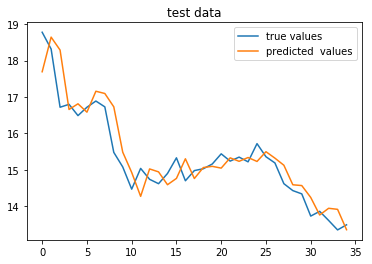

In [129]:
plt.plot(gd_truth, label='true values')
plt.plot(pred_val, label='predicted  values')
plt.legend()
plt.title('test data')
plt.show()